# Backstripping finally!

<div class="alert alert-block alert-success">
_Learning points_: the depths of a stratigraphic horizon over time is partly a result of the loading by overlying sediment. Backstripping is the removal of this loading effect to reveal the driving force for tectonic subsidence, with the assumption that it is taking place in a water-filled basin. Backstripping allows different boreholes or stratigraphic sections to be compared in terms of their water-loaded tectonic subsidence. </div>

## Introduction

Backstripping simulation is a backward-in-time process where at each time step one removes the top-most (youngest) sediment layer together with its effects on the underlying sediments (via decompaction) and the Earth’s crust (isostasy). The purpose of this exercise is to compute the temporal evolution of the component of crustal subsidence that is not attributed to sediment loading. This subsidence is called **thermo-tectonic**, which essentially means that we have no clue as to why it happened but we suspect that it was caused by some combination of tectonic forces and thermal effects.

The idea behind backstripping is based on the following simplified viewpoint of the geological evolution. Let’s consider an abstract geological column at some location with water depth $w$ and sediment thickness $S$, as well as the same location at some previous geological time when no sediments were present and the water depth was $w_0$. The difference in water depth could have been caused by several reasons: 
+ the crustal deflection due to the sediment load $\xi$, 
+ the global sea level change $\Delta$, and finally 
+ the thermo-tectonic subsidence $T$.

<img src="figs/ex5-fig1.png" width="60%">

As you can see from the figure above, these variables can be linked together via

$$T = w + S - \xi - \Delta - w_0$$

The $w_0$ term makes sure that $T_0 = 0$, the model calculates incremental subsidence with respect to $t = 0$, and we  define $T_0$ as the zero baseline.

From all the symbols in this equation the model expects $w(t)$, $\Delta(t)$ and $S_p$ (present-day sediment thickness) as inputs and it computes $\xi(t)$, $S(t)$ and $T(t)$ as outputs.

## Crustal deflection

For a 1D crustal deflection the simplest model is that of a hydrostatic equilibrium (or **Airy isostasy**). It says that there is a level deep down in the Earth’s mantle at which the hydrostatic pressure remains constant regardless of what happens at the surface. When we push the crust down by $\xi$, we reduce the pressure contribution from the mantle with respect to this level by $\rho_mg\xi$. 

According to the isostasy theory that same amount of pressure now needs to come from the load on top of the crust. We can see from the figure that the incremental crustal load has three components: 
+ sediment load, 
+ water load due to deflection and 
+ water load due to sea level change 

$$\rho_mg\xi = \rho_bgS + \rho_wg(\xi-S) + \rho_wg\Delta$$

$$\xi = \frac{\rho_b-\rho_w}{\rho_m-\rho_w}S + \frac{\rho_w}{\rho_m-\rho_w}\Delta$$

By the way, $\rho_m$, $\rho_b$ and $\rho_w$ are densities of mantle, sediment column ($b$ is for bulk density) and water respectively. When we substitute this expression for $\xi$ back into the backstripping equation, we obtain the final result:

$$T = w - w_0 + \frac{\rho_m - \rho_b}{\rho_m - \rho_w}S - \frac{\rho_m}{\rho_m - \rho_w}\Delta$$

Note that these equations also apply when sediments are exposed to air instead of water (_e.g. mountains_), if we set $\rho_w = 0$.

## Sediment decompaction

Let’s now look more closely at how to compute sediment properties $S(t)$ and $\rho_b(t)$. Bulk density is by definition

$$\rho_b(t) = \phi(t)\rho_w + [1-\phi(t)]\rho_s$$

where $\phi$ is porosity and $\rho_s$ is sediment rock density (_e.g. pure quartz_). Notice, that the corresponding term in the expression for $\xi$ is

$$(\rho_b(t)-\rho_w)S(t) = (\rho_s - \rho_w)[1-\phi(t)]S(t) = (\rho_s - \rho_w)h$$

where $h = [1-\phi(t)]S(t)$ is the “_rock thickness_” of the sediment column which does not change over time if we neglect chemical reactions. That is, a sediment layer may compact over time due to grains being squeezed together from the weight above, but the actual mass of rock remains the same.

This is good news because it means that there is no need to calculate $\rho_b(t)$ over time. Instead, we can get away with calculating $h$ only once from the present-day rock properties. But we still have to find $S(t)$ and for this we need a decompaction model.

To derive it we will rely again on the fact that $h$ is constant over time. We will also assume that the temporal change of porosity can be captured with a porosity-depth relationship $\phi(z)$. In other words, porosity changes over time only due to the sediments progressive burial and hence $\phi(t) = \phi(z(t))$.

Let’s consider an arbitrary sediment layer of thickness $S_p$ and calculate its “_rock thickness_” $h$ from the present-day stratigraphic information:

$$h = \int_{z_{\mathrm{max}}}^{z_{\mathrm{max}}+S_p}[1-\phi(z)]\mathrm{d}z = S_p - \int_{z_{\mathrm{max}}}^{z_{\mathrm{max}}+S_p}\phi(z)\mathrm{d}z$$

Here $z_{\mathrm{max}}$ is the maximum burial depth of our layer, which does not necessarily equal its present-day burial depth if a major erosional event caused its uplift sometime in the geologic past. From knowing $h$ we can then compute $S(z)$ at another burial depth $z$ by finding the zero of the following non-linear function:

$$f(S) = S - \int_{z}^{z+S}\phi(z)\mathrm{d}z - h$$

which enforces sediment mass concentration during compaction.

In practical terms, we need to employ two numerical methods to model sediment compaction. First is the numerical integration of a porosity-depth relationship. A typical theoretical $\phi(z)$ function exhibits a smooth gradual and monotonic change over depth and hence a [second-order Gauss quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature) is sufficient to approximate the integral:

$$\Delta z = \frac{z_2-z_1}{2}, \quad \bar{z} = \frac{z_1+z_2}{2}$$

$$\int_{z_1}^{z_2}\phi(z)\mathrm{d}z\approx\Delta z\left[\phi\left(\bar{z}-\frac{\sqrt{3}}{3}\Delta z\right)+\phi\left(\bar{z}+\frac{\sqrt{3}}{3}\Delta z\right)\right]$$

The second required numerical technique is the [Newton algorithm](https://en.wikipedia.org/wiki/Newton%27s_method) for solving $f(S)=0$:

$$S^{(0)}=h,\quad S^{(j+1)}=S^{(j)}-\frac{f(S^{(j)})}{f^{'}(S^{(j)})}=S^{(j)}-\frac{f(S^{(j)})}{1-\phi(z_{i}+S^{(j)})}$$

## Sample implementation

Here is a sample Python implementation of the described model. For our implementation we will use Athy’s porosity-depth relationship, $\phi(z) = \phi_0 \exp(-cz)$, where $\phi_0$ is a surface porosity and $c$ is a compaction rate. We will only consider depositional events, that is, once a layer had been deposited, it remained in place from then on without being eroded.

We first implement the decompaction related functionality in the Layer class:

In [1]:
import math
 
from traits.api import (HasStrictTraits, Function, Float,
                        Property, cached_property)

In [2]:
class Layer(HasStrictTraits):
    maximum_burial = Float
    present_thickness = Float
    porosity_function = Function
    compaction_rate = Float
    surface_porosity = Float
    sediment_density = Float
    sediment_thickness = Property(depends_on=['present_thickness,'
                                              'maximum_burial'])
 
    def set_rock_properties(self, properties_dict):
        self.surface_porosity = properties_dict['surface_porosity']
        self.compaction_rate = properties_dict['compaction_rate']
        self.sediment_density = properties_dict['sediment_density']
 
    @cached_property
    def _get_sediment_thickness(self):
        """ Compute sediment thickness. """
        z0 = self.maximum_burial
        z1 = z0 + self.present_thickness
        water_thickness = self.integrate_porosity_function(z0, z1)
        return self.present_thickness - water_thickness
 
    def integrate_porosity_function(self, z0, z1):
        """ Numerically integrate porosity function over the given interval. """
        w = 0.5773502691896257  # sqrt(3)/3
        halflength = 0.5 * (z1 - z0)
        midpoint = 0.5 * (z0 + z1)
 
        porosity_0 = self.porosity_function(self, midpoint + halflength * w)
        porosity_1 = self.porosity_function(self, midpoint - halflength * w)
        return halflength * (porosity_0 + porosity_1)
 
    def thickness_at_depth(self, depth, eps=1e-6):
        """ Computes layer's thickness if buried at a given depth. """
        thickness = self.present_thickness  # initial guess
        # Newton iteration
        carry_on = True
        while carry_on:
            water_thickness = self.integrate_porosity_function(depth, depth + thickness)
            function_value = thickness - self.sediment_thickness - water_thickness
            derivative_value = 1.0 - self.porosity_function(self, depth + thickness)
            thickness -= function_value / derivative_value
            carry_on = abs(function_value) > eps
        return thickness
 
    def sediment_weight(self, constants):
        """ Layer weight above that of water. """
        return (self.sediment_density - constants.water_density) \
            * constants.gravity * self.sediment_thickness

def athy_porosity(layer, z):
    """ Athy's porosity-depth relationship. """
    return layer.surface_porosity * math.exp(-layer.compaction_rate * z)


The `Layer` objects know how to compute their rock thickness and how thick they would be at different burial depths. To describe a collection of layers deposited at some time with a certain geologic context, we also introduce the `Deposition` class, as well as the `EventManager` class which holds a collection of deposition events and can perform calculations which require knowledge of the burial history:

In [3]:
from sortedcontainers import SortedListWithKey
from traits.api import HasStrictTraits, Float, Instance

class Deposition(HasStrictTraits):
    age = Float
    bathymetry = Float
    sea_level = Float
    layer = Instance(Layer)

class EventManager(HasStrictTraits):
    events = Instance(SortedListWithKey, kw={'key': lambda e: e.age})
    initial_age = Float
    initial_sea_level = Float
    initial_bathymetry = Float
 
    def add_events(self, events):
        self.events.update(events)
 
    def reconstruct_burial_history(self):
        """ Compute maximum burial depths for all the deposited layers. """
        current_burial = 0.0
        for event in self.events:
            event.layer.maximum_burial = current_burial
            current_burial += event.layer.present_thickness
 
    def decompact_layers(self, starting_event_id, constants):
        """ Decompaction of a sediment column. """
        current_burial = 0.0
        thickness_list = []
        weight_list = []
        for event in self.events[starting_event_id:]:
            thickness = event.layer.thickness_at_depth(current_burial)
            weight = event.layer.sediment_weight(constants)
            current_burial += thickness
            thickness_list.append(thickness)
            weight_list.append(weight)
 
        return thickness_list, weight_list
 
    def sea_level_change(self, event_id):
        """ Sea level change for a given event ID. """
        return self.events[event_id].sea_level - self.initial_sea_level
 
    def bathymetry(self, event_id):
        """ Water depth value for a given event ID. """
        return self.events[event_id].bathymetry

In [4]:
class PhysicalConstants(HasStrictTraits):
    gravity = Float(9.81)
    water_density = Float(1000)
    mantle_density = Float(3300)

Using a setup `EventManager` object, the actual backstripping algorithm is trivial to implement:

In [5]:
def compute_deflection(sediment_weight, sea_level_change, constants):
    """ helper function for Airy isostasy. """
    total_weight = sediment_weight + constants.gravity * constants.water_density * sea_level_change
    return total_weight / (constants.gravity * (constants.mantle_density - constants.water_density))
 
def compute_subsidence(event_manager, constants=PhysicalConstants()):
    """ Actual backstripping is performed here. """
    subsidence = []
    thickness_evolution = []
    for event_id in range(len(event_manager.events)):
        thickness, weight = event_manager.decompact_layers(event_id, constants)
        total_thickness = sum(thickness)
        total_weight = sum(weight)
        sea_level_change = event_manager.sea_level_change(event_id)
        bathymetry = event_manager.bathymetry(event_id)
        deflection = compute_deflection(total_weight, sea_level_change, constants)
        s = (bathymetry + total_thickness - deflection - sea_level_change
             - event_manager.initial_bathymetry)
        subsidence.append(s)
        thickness_evolution.append(thickness)
    return subsidence[::-1], thickness_evolution[::-1]

In [55]:
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib.pyplot import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

from traits.api import HasStrictTraits, Float

import operator

def accumulate(iterable, func=operator.add):
    it = iter(iterable)
    try:
        total = next(it)
    except StopIteration:
        return
    yield total
    for element in it:
        total = func(total, element)
        yield total
            
def prepare_events(ages, bathymetries, sea_levels, thicknesses, rock_types, rock_properties):
    """ Package inputs into an EventManager instance. """
    events = []
    for age, bathymetry, sea_level, thickness, rock_type in zip(
          ages[1:], bathymetries[1:], sea_levels[1:], thicknesses, rock_types):
        layer = Layer(present_thickness=thickness, porosity_function=athy_porosity)
        layer.set_rock_properties(rock_properties[rock_type])
        event = Deposition(age=age, bathymetry=bathymetry, sea_level=sea_level, layer=layer)
        events.append(event)

    event_manager = EventManager(initial_age=ages[0],
                                 initial_sea_level=sea_levels[0],
                                 initial_bathymetry=bathymetries[0])
    event_manager.add_events(events)
    event_manager.reconstruct_burial_history()
    return event_manager


def compute_deflection(sediment_weight, sea_level_change, constants):
    """ helper function for Airy isostasy. """
    total_weight = sediment_weight + constants.gravity * constants.water_density * sea_level_change
    return total_weight / (constants.gravity * (constants.mantle_density - constants.water_density))


def compute_subsidence(event_manager, constants=PhysicalConstants()):
    """ Actual backstripping is performed here. """
    subsidence = []
    thickness_evolution = []
    for event_id in range(len(event_manager.events)):
        thickness, weight = event_manager.decompact_layers(event_id, constants)
        total_thickness = sum(thickness)
        total_weight = sum(weight)
        sea_level_change = event_manager.sea_level_change(event_id)
        bathymetry = event_manager.bathymetry(event_id)
        deflection = compute_deflection(total_weight, sea_level_change, constants)
        s = (bathymetry + total_thickness - deflection - sea_level_change
             - event_manager.initial_bathymetry)
        subsidence.append(s)
        thickness_evolution.append(thickness)
    return subsidence[::-1], thickness_evolution[::-1]


def plot_results(ages, subsidence, thickness_list, sea_levels, bathymetries):
    """ Plots tectonic subsidence and sediment thickness change over time. """
    # plot setup
    fig = plt.figure(figsize=(12, 5), facecolor='white')
    axes = plt.gca()
    plt.grid()
    axes.invert_xaxis()
    axes.set_xlabel("Time [Ma]", labelpad=15)
    axes.set_ylabel("Depth [m]", labelpad=15)
    axes.tick_params(axis='both', which='major', pad=10, direction='out', size=5)

    axes.xaxis.label.set_fontsize(14)
    axes.yaxis.label.set_fontsize(14)
    for item in axes.get_xticklabels() + axes.get_yticklabels():
        item.set_fontsize(10)

    # actual data
    subs, = plt.plot(ages, [0] + subsidence, '--', color='#0077B8', lw=5, label='Subsidence')
    plt.legend(handles=[subs], loc=3)
    horizon_offset = [w - bathymetries[0] - (s - sea_levels[0])
                      for w, s in zip(bathymetries, sea_levels)]
    horizons = [list(accumulate(chain([ho], t))) for ho, t in zip(horizon_offset, thickness_list)]

    axes.set_xlim([max(ages), min(ages)])
    axes.set_ylim([max(max(h) for h in horizons), min(horizon_offset)])

    patches = []
    n_patches = len(ages) - 1
    x_indices = [n_patches]
    for i, j in enumerate(reversed(range(n_patches))):
        x_indices = [j] + x_indices + [j+1]
        y_indices = list(range(i+1)) + list(range(i+1, -1, -1))
        points = [[ages[x_id], horizons[x_id-1][y_id]] for x_id, y_id in zip(x_indices, y_indices)]
        patches.append(Polygon(points))
    # we have to fix the last polygon
    xy = patches[-1].get_xy()
    xy[0, 1] = xy[-1, 1] = 0.0
    patches[-1].set_xy(xy)

    p = PatchCollection(patches, cmap='terrain', alpha=0.7)
    p.set_array(np.arange(n_patches))
    axes.add_collection(p)
    plt.show()

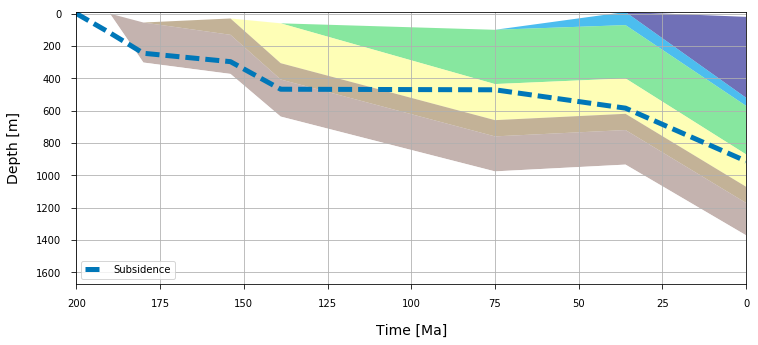

In [56]:
# setup layers
rock_properties = [
    {'surface_porosity': 0.63, 'compaction_rate': 0.51e-3, 'sediment_density': 2720.0},
    {'surface_porosity': 0.49, 'compaction_rate': 0.27e-3, 'sediment_density': 2650.0},
    {'surface_porosity': 0.70, 'compaction_rate': 0.71e-3, 'sediment_density': 2710.0},
    {'surface_porosity': 0.40, 'compaction_rate': 0.60e-3, 'sediment_density': 2720.0},
    {'surface_porosity': 0.05, 'compaction_rate': 0.20e-3, 'sediment_density': 2960.0},
]
 
ages = [200, 190, 180, 154, 139, 75, 36, 0]
sea_levels = [10, -5, 0, -20, -50, 80, 0, -40]
bathymetries = [-10, 30, 10, 20, 30, 50, 0, 30]
rock_types = [4, 1, 4, 3, 1, 2, 0]
thicknesses = [300, 200, 100, 200, 300, 50, 500]
 
event_manager = prepare_events(ages, bathymetries, sea_levels, thicknesses, rock_types, rock_properties)
subsidence, thickness_evolution = compute_subsidence(event_manager)
plot_results(ages, subsidence, thickness_evolution, sea_levels, bathymetries)

## Subsidence history for different sea-level history

Find the tectonic history associated to the following sedimentary column using the python code provided above. 

<img src="figs/ex5-fig2.png" width="80%">

### First apply it with sea-level 1

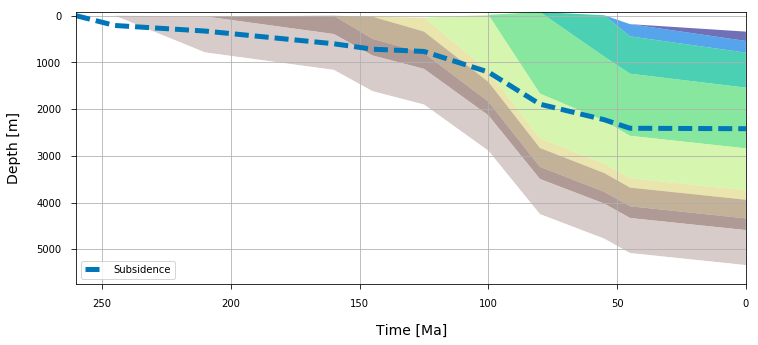

In [57]:
# setup layers
rock_properties = [
    {'surface_porosity': 0.63, 'compaction_rate': 0.51e-3, 'sediment_density': 2720.0}, # shales type 0
    {'surface_porosity': 0.49, 'compaction_rate': 0.27e-3, 'sediment_density': 2650.0}, # sandstones type 1
    {'surface_porosity': 0.70, 'compaction_rate': 0.71e-3, 'sediment_density': 2710.0}, # chalk type 2
    {'surface_porosity': 0.40, 'compaction_rate': 0.60e-3, 'sediment_density': 2720.0}, # limestones type 3
    {'surface_porosity': 0.20, 'compaction_rate': 0.60e-3, 'sediment_density': 2870.0}, # dolomite type 4
    {'surface_porosity': 0.05, 'compaction_rate': 0.20e-3, 'sediment_density': 2960.0}, # anhydrite type 5
    {'surface_porosity': 0.20, 'compaction_rate': 0.30e-3, 'sediment_density': 2650.0}, # quartzite type 6
]
 
ages = [260, 245, 210, 160, 145, 125, 100, 80, 55, 45, 0]
sea_levels1 = [20, 25, 0, -50, -20, 5, 80, 100, 60, 50, 0]
bathymetries = [30, 50, 10, -20, 30, -5, 10, 100, 250, 400, 300]
rock_types = [6, 5, 1, 4, 3, 1, 2, 0, 1, 0]
thicknesses = [400, 750, 250, 400, 200, 900, 1300, 750, 250, 200]
 
event_manager = prepare_events(ages, bathymetries, sea_levels1, thicknesses, rock_types, rock_properties)
subsidence1, thickness_evolution = compute_subsidence(event_manager)
plot_results(ages, subsidence1, thickness_evolution, sea_levels1, bathymetries)

### Second apply it with sea-level 2

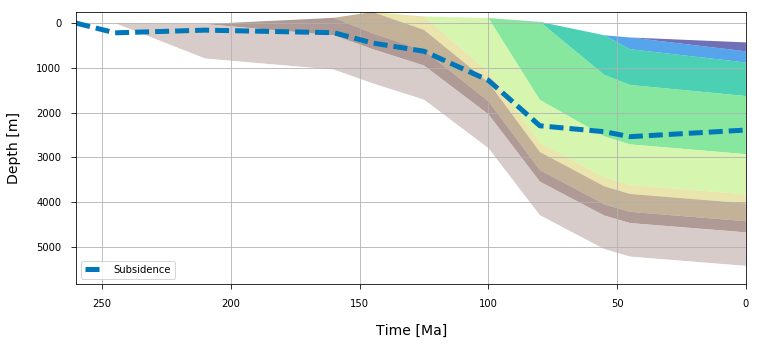

In [58]:
sea_levels2 = [0, 0, 100, 200, 150, 80, 10, -200, -100, -60, 0]
 
event_manager = prepare_events(ages, bathymetries, sea_levels2, thicknesses, rock_types, rock_properties)
subsidence2, thickness_evolution = compute_subsidence(event_manager)
plot_results(ages, subsidence2, thickness_evolution, sea_levels2, bathymetries)

### Compare subsidence histories

Using the following plotting functions compare the two scenarios.

In [59]:
def plot_subs(ages, subsidence1, subsidence2):
    
    """ Plots tectonic subsidence and sediment thickness change over time. """
    # plot setup
    fig = plt.figure(figsize=(12, 5), facecolor='white')
    axes = plt.gca()
    plt.grid()
    axes.invert_xaxis()
    axes.set_xlabel("time [Ma]", labelpad=15)
    axes.set_ylabel("subsidence history [m]", labelpad=15)
    axes.tick_params(axis='both', which='major', pad=10, direction='out', size=5)

    axes.xaxis.label.set_fontsize(14)
    axes.yaxis.label.set_fontsize(14)
    for item in axes.get_xticklabels() + axes.get_yticklabels():
        item.set_fontsize(10)

    # actual data
    subs, = plt.plot(ages, [0] + subsidence1, '--', color='#ff5050', lw=3, label='Subsidence 1')
    subs2, = plt.plot(ages, [0] + subsidence2, '--', color='#0077B8', lw=3, label='Subsidence 2')
    plt.legend(handles=[subs,subs2], loc=3)
    axes.invert_yaxis()
    plt.show()
    
def plot_sea(ages, sea_levels1, sea_levels2):
    
    """ Plots tectonic subsidence and sediment thickness change over time. """
    # plot setup
    fig = plt.figure(figsize=(12, 5), facecolor='white')
    axes = plt.gca()
    plt.grid()
    axes.invert_xaxis()
    axes.set_xlabel("time [Ma]", labelpad=15)
    axes.set_ylabel("sea-level [m]", labelpad=15)
    axes.tick_params(axis='both', which='major', pad=10, direction='out', size=5)

    axes.xaxis.label.set_fontsize(14)
    axes.yaxis.label.set_fontsize(14)
    for item in axes.get_xticklabels() + axes.get_yticklabels():
        item.set_fontsize(10)

    # actual data
    subs, = plt.plot(ages, [0] + sea_levels1[1:], '--', color='#ff5050', lw=3, label='Sea-level 1')
    subs2, = plt.plot(ages, [0] + sea_levels2[1:], '--', color='#0077B8', lw=3, label='Sea-level 2')
    plt.legend(handles=[subs,subs2], loc=3)
    #axes.invert_yaxis()
    plt.show()

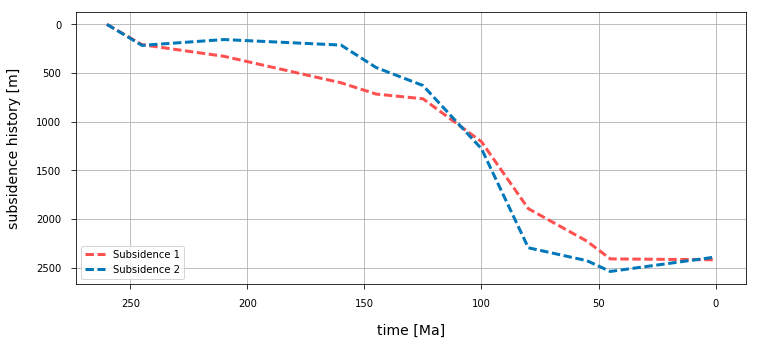

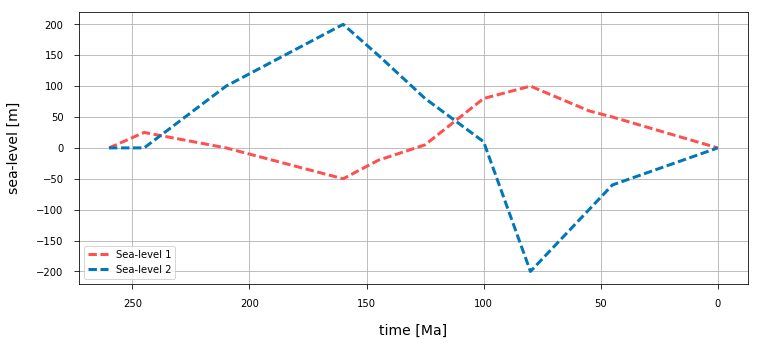

In [60]:
plot_subs(ages, subsidence1, subsidence2)
plot_sea(ages, sea_levels1, sea_levels2)